D:\сахненко\4 лаба\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\сахненко\4 лаба\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0, Total loss: 9.3246
Epoch 50, Total loss: 2.2998
Epoch 100, Total loss: 2.0636
Epoch 150, Total loss: 1.9786
Epoch 200, Total loss: 1.9322
Epoch 250, Total loss: 1.9022
✅ Готово! Збережено як result.jpg


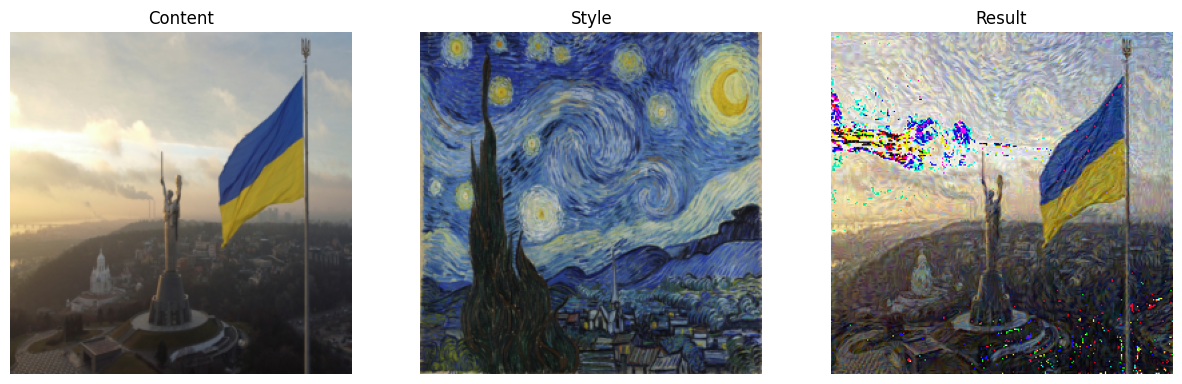

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

# --------------------
# Налаштування
# --------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

content_img_path = "content.jpg"
style_img_path = "style.jpg"
output_img_path = "result.jpg"

image_size = 512 if torch.cuda.is_available() else 256
loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# --------------------
# Завантаження зображень
# --------------------
def load_image(img_path):
    image = Image.open(img_path).convert('RGB')
    image = loader(image).unsqueeze(0)
    return image.to(device)

content_img = load_image(content_img_path)
style_img = load_image(style_img_path)

# --------------------
# Відображення зображення
# --------------------
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

# --------------------
# Грам-матриця
# --------------------
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(c * h * w)

# --------------------
# Модель VGG19
# --------------------
vgg = models.vgg19(pretrained=True).features.to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False

# --------------------
# Шари для контенту і стилю
# --------------------
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

class GetFeatures(nn.Module):
    def __init__(self, model):
        super(GetFeatures, self).__init__()
        self.model = model
        self.layers = {
            '0': 'conv_1',
            '5': 'conv_2',
            '10': 'conv_3',
            '19': 'conv_4',
            '28': 'conv_5'
        }

    def forward(self, x):
        features = {}
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.layers:
                features[self.layers[name]] = x
        return features

model = GetFeatures(vgg)

# --------------------
# Витягуємо ознаки
# --------------------
content_features = model(content_img)
style_features = model(style_img)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# --------------------
# Стартуємо із контент-зображення
# --------------------
generated = content_img.clone().requires_grad_(True).to(device)

# --------------------
# Оптимізація
# --------------------
optimizer = optim.Adam([generated], lr=0.003)

style_weight = 1e6
content_weight = 1
epochs = 300

for i in range(epochs):
    optimizer.zero_grad()

    generated_features = model(generated)

    # Контент-втрата
    content_loss = torch.mean((generated_features['conv_4'] - content_features['conv_4']) ** 2)

    # Стиль-втрата
    style_loss = 0
    for layer in style_layers:
        gen_feature = generated_features[layer]
        gen_gram = gram_matrix(gen_feature)
        style_gram = style_grams[layer]
        style_loss += torch.mean((gen_gram - style_gram) ** 2)

    # Загальна втрата
    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
        print(f"Epoch {i}, Total loss: {total_loss.item():.4f}")

# --------------------
# Збереження результату
# --------------------
generated_img = generated.detach().cpu().squeeze(0)
generated_img_pil = transforms.ToPILImage()(generated_img)
generated_img_pil.save(output_img_path)
print("✅ Готово! Збережено як result.jpg")

# --------------------
# Відображення зображень
# --------------------
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
imshow(content_img, "Content")

plt.subplot(1,3,2)
imshow(style_img, "Style")

plt.subplot(1,3,3)
imshow(generated, "Result")

plt.show()
